# Task 2: Zero-shot Case

### Task Definition
As an extension of the previous task please conceptualize and present an approach
that can deal with scenarios where no training data is available at all. Think about this
as a scenario where a customer cannot define all categories of interest prior to the
application of the system but still wants to get notified when a new object type has been
found in order to extend his database and improve the system over time.You can use the data provided in coco_crops_zero_shot/ as inspiration or to even
experiment with some ideas.

### My Approach (ilker)
As a preliminary step, I train a classifier in Task 1. Then, I design a heuristic method that works on top of the classifier. The method decides whether an image is novel or not.

The application scenerio can be formulated as follows:

Let's imagine a costumer have a set of small dataset for known categories. This set is "coco_crops_few_shot/". However, she/he cannot define all categories. And during the application, there could be detected object instances, which belogs to a non-defined object category. So, this category is novel according to the prior known object categories. Our system should notify the customer with "novel objects". I accept "coco_crops_zero_shot/" dataset includes images with novel objects.

My hypothesis is that the classifier should have high confidence for object categories that it is already trained on. However, it should have lower confidence for novel samples since it is not trained with those samples.

In my solution, I treat the max probs of a test samples, which are assigned by the classifier, as the confidence score. And also, I implement an adaptive thresholding mechanism that can be used to decide whether a test sample with computed confidence score should be considered normal or novel.

#### Discussion
The advantages of this method is that:
- There is no explicit model training for novelty detection.
- We don't need to define a novelty decision threshold by hand.
- We have a parameter which sets the threshold according to prior knowledge about the task. Therefore, it can be adjusted for different use-cases. For example, if we know that our training data is not that good, then we can discard some portion of our training data, and we can extend our dataset with novel samples. Or, if we believe that we have good training data then we can be more picky during extended our dataset with novel samples.

Future work could be:
- We consider max probas as predictor confidence. However, second or third max probas, or even looking at all probas might be more informative to decide the predictor confidence.

- Another method, which is independent of this work, could be comparing the features of training samples, and test samples to decide novelty. I would like to implement this idea as an alternative. However, I skip this for the sake of time.

## Preliminary Step: Use Task 1 classifier

Load the classifier trained for Task 1.

In [1]:
import pickle
import clip 
import torch
import torchvision 

from utils import get_features


device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Load the model from disk
classifier = pickle.load(open("task1_classifier.sav", 'rb'))

print("Available device: ", device)
print("Classifier: ", classifier)

Available device:  cpu
Classifier:  LogisticRegression(C=0.316, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=1,
                   warm_start=False)


## Load datasets
Load the datasets, which one of them is available for the customer (i.e., fewshot dataset), and the other dataset is not available for the customer (i.e., zeroshot dataset).

In [2]:
fewshot_test_dataset = torchvision.datasets.ImageFolder(root="../data/coco_crops_few_shot/test", transform=preprocess)
zeroshot_test_dataset = torchvision.datasets.ImageFolder(root="../data/coco_crops_zero_shot/test", transform=preprocess)

# Calculate the image features for few shot test samples.
fewshot_test_features, fewshot_test_labels = get_features(fewshot_test_dataset, model, device)

# Calculate the image features for few shot test samples.
# Note that the labels should not be available.
zeroshot_test_features, _ = get_features(zeroshot_test_dataset, model, device)

print("Few shot test features, Few shot test labels: {}, {}".format(fewshot_test_features.shape, fewshot_test_labels.shape))
print("Zero shot test features {}".format(zeroshot_test_features.shape))


100%|██████████| 1/1 [00:01<00:00,  1.89s/it]

Few shot test features, Few shot test labels: (503, 512), (503,)
Zero shot test features (38, 512)


## Step 1: Find maximum probas

First, let's find maximum probabilites assigned by the classifier. Our assumption is that the network has high confidence if it assigns high proba to a certain category.

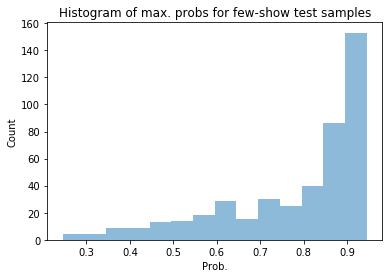

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Predict probas.
probas = classifier.predict_proba(fewshot_test_features)

# Get maximum of probas.
max_probas = np.max(probas,axis=1)

# Find min and max value to create histogram bins.
minValue, maxValue = np.min(max_probas), np.max(max_probas)
bins = np.arange(minValue, maxValue, 0.05)

# Plot the histogram of class probabilities.
h1 = plt.hist(max_probas, bins, alpha=0.5)
plt.title("Histogram of max. probs for few-show test samples")
plt.xlabel("Prob.")
plt.ylabel("Count")
plt.show()

## Step 2: Fit a prior distribution to probs of "known" categories

In here, we fit the Normal distribution to the max probs. histogram. The histogram will be plotted after running the cell. Blue dashed line indicates the mean of the fitted distribution, and green dotted line shows that the mean-2*variance.

Why do we need to fit Normal distribution, but not other analytical shapes (exponential, Bernoulli etc.)? It is empirical choice since the estimated parameters (i.e., they are mean and variance for Normal distribution) can be used as more intuitive thresholds for novelty detection.

Loc:  0.8014056424773003
Scale:  0.167064784762624


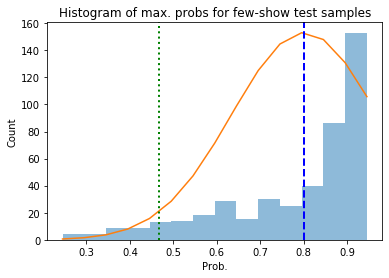

In [4]:

# Fit Normal distribution to the histogram. 
# Loc and scale are the mean and variance for Normal distribution.
loc, scale  = stats.norm.fit(max_probas)
print("Loc: ", loc)
print("Scale: ", scale)

# Fitted line
best_fit_line = stats.norm.pdf(h1[1], loc, scale)

plt.title("Histogram of max. probs for few-show test samples")

# Plot histogram bars again just for visualization.
h1 = plt.hist(max_probas, bins, alpha=0.5, label='normal')

# Plot the fitted line.
plt.plot(bins, best_fit_line*((np.max(h1[0]))/np.max(best_fit_line)))


plt.axvline(loc, color='blue', linestyle='dashed', linewidth=2)
plt.axvline(loc-2*scale, color='green', linestyle='dotted', linewidth=2)
plt.xlabel("Prob.")
plt.ylabel("Count")
plt.show()


Now, let's just check the distribution of max probabilities for zero-show test samples. According to our hypothesis, they should have lower max probas than the few-show samples since the classifier will be less confident on decisions. Orange bars indicates the max probas of novel samples. Blue bars indicates the max probas of normal samples (i.e., test samples in fewshot dataset).

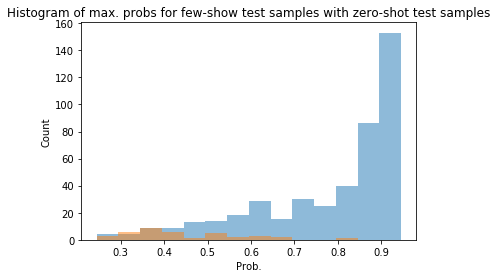

In [4]:
# Plot histogram bars again just for visualization.
h1 = plt.hist(max_probas, bins, alpha=0.5, label='normal')
probas = classifier.predict_proba(zeroshot_test_features)
zeroshow_max_probas = np.max(probas,axis=1)

h2 = plt.hist(zeroshow_max_probas, bins, alpha=0.5, label='normal')
plt.title("Histogram of max. probs for few-show test samples with zero-shot test samples")
plt.xlabel("Prob.")
plt.ylabel("Count")
plt.show()

## Step 3: Adaptive threshold for novelty decision

The final step is computing a threshold to decide whether a given input image is novel or normal based on max probs computed by the classifier. In other words, this steps explains what the threshold is to trust the predictor's confidence. 

If the max prob of a sample is higher than threshold then we consider the network is confident enough. However, if the max prob is lower than the threshold then it means the classifier is not confident enough, and we should accept this sample as a novel (i.e., different from the existing samples in the collected dataset).

**C** is a hyper-parameter, which represents our trust for the predictor confidence.
It should be set according a use-case. We can discuss the trade-off for choosing the parameter in the meeting.


In [6]:
for C in [0.5, 1, 1.5, 2, 2.5, 3]:
    decision_threshold = loc - C*scale

    probas = classifier.predict_proba(fewshot_test_features)
    fewshow_max_probas = np.max(probas,axis=1)
    print("C:", C)
    print("The percentage of novel samples in training set (lower is better)", np.mean(fewshow_max_probas<decision_threshold)*100)

    probas = classifier.predict_proba(zeroshot_test_features)
    zeroshow_max_probas = np.max(probas,axis=1)
    print("The percentage of novel samples in test set (higher is better)", np.mean(zeroshow_max_probas<decision_threshold)*100)


C: 0.5
The percentage of novel samples in training set (lower is better) 24.85089463220676
The percentage of novel samples in test set (higher is better) 97.36842105263158
C: 1
The percentage of novel samples in training set (lower is better) 18.687872763419485
The percentage of novel samples in test set (higher is better) 92.10526315789474
C: 1.5
The percentage of novel samples in training set (lower is better) 10.934393638170974
The percentage of novel samples in test set (higher is better) 78.94736842105263
C: 2
The percentage of novel samples in training set (lower is better) 5.566600397614314
The percentage of novel samples in test set (higher is better) 63.1578947368421
C: 2.5
The percentage of novel samples in training set (lower is better) 3.3797216699801194
The percentage of novel samples in test set (higher is better) 36.84210526315789
C: 3
The percentage of novel samples in training set (lower is better) 0.9940357852882704
The percentage of novel samples in test set (higher 

## Visualize some samples

Let's visualize some samples from few shot samples. Note that these are test samples, which belong to the categories that the classifier is trained on. The number in paranthesis indicates the max probs computed by the classifier.


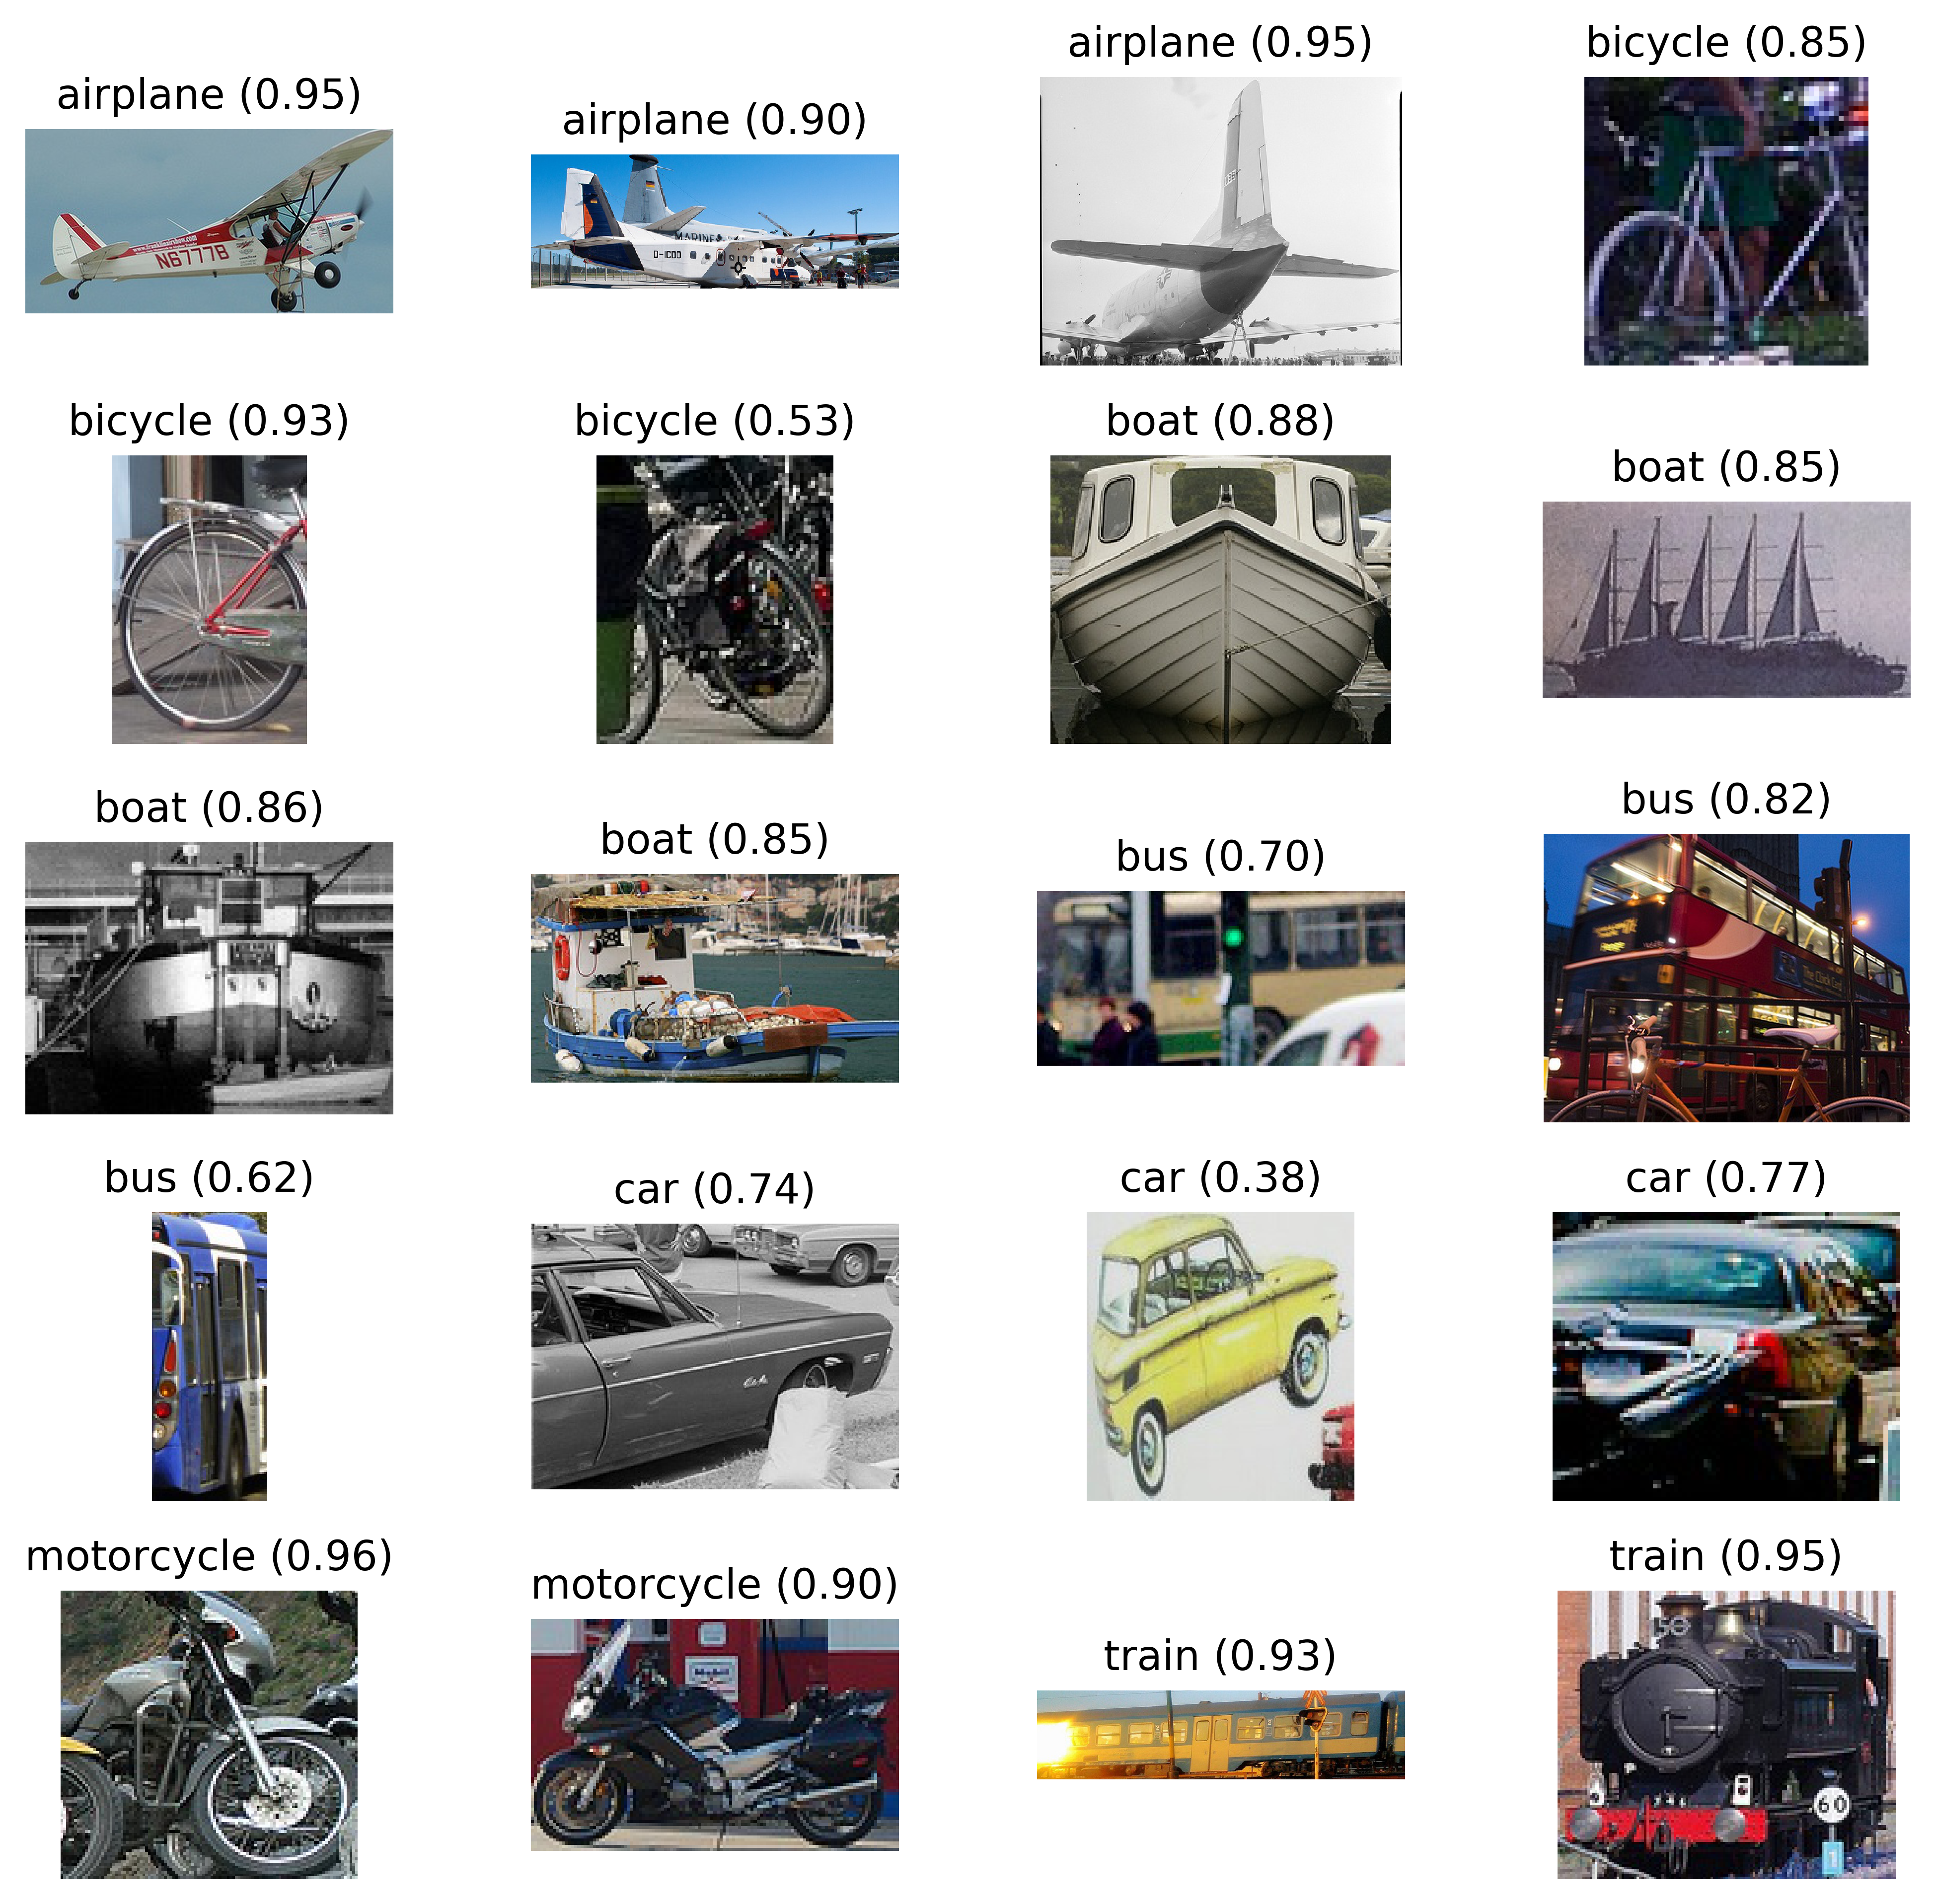

In [9]:
import numpy as np
import matplotlib.pyplot as plt


w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
fewshot_test_dataset = torchvision.datasets.ImageFolder(root="../data/coco_crops_few_shot/test")
idx_to_classes = {value:key for key, value in fewshot_test_dataset.class_to_idx.items()}
#print(idx_to_classes)

cnt = 0
for i in range(1, columns*rows +1):
    img = (fewshot_test_dataset[cnt][0])
    
    fig.add_subplot(rows, columns, i)
    fig.tight_layout() 
    
    plt.title(idx_to_classes[fewshot_test_dataset[cnt][1]] + " ({:.02f})".format(max_probas[cnt]))

    plt.imshow(img)
    plt.axis("off")
    cnt+=20

plt.show()

## Visualize zero-shot samples.

Visualize the zero-shot samples with the computed max probs by the classifier. These numbers are relatively lower compared to the figure in above cell.

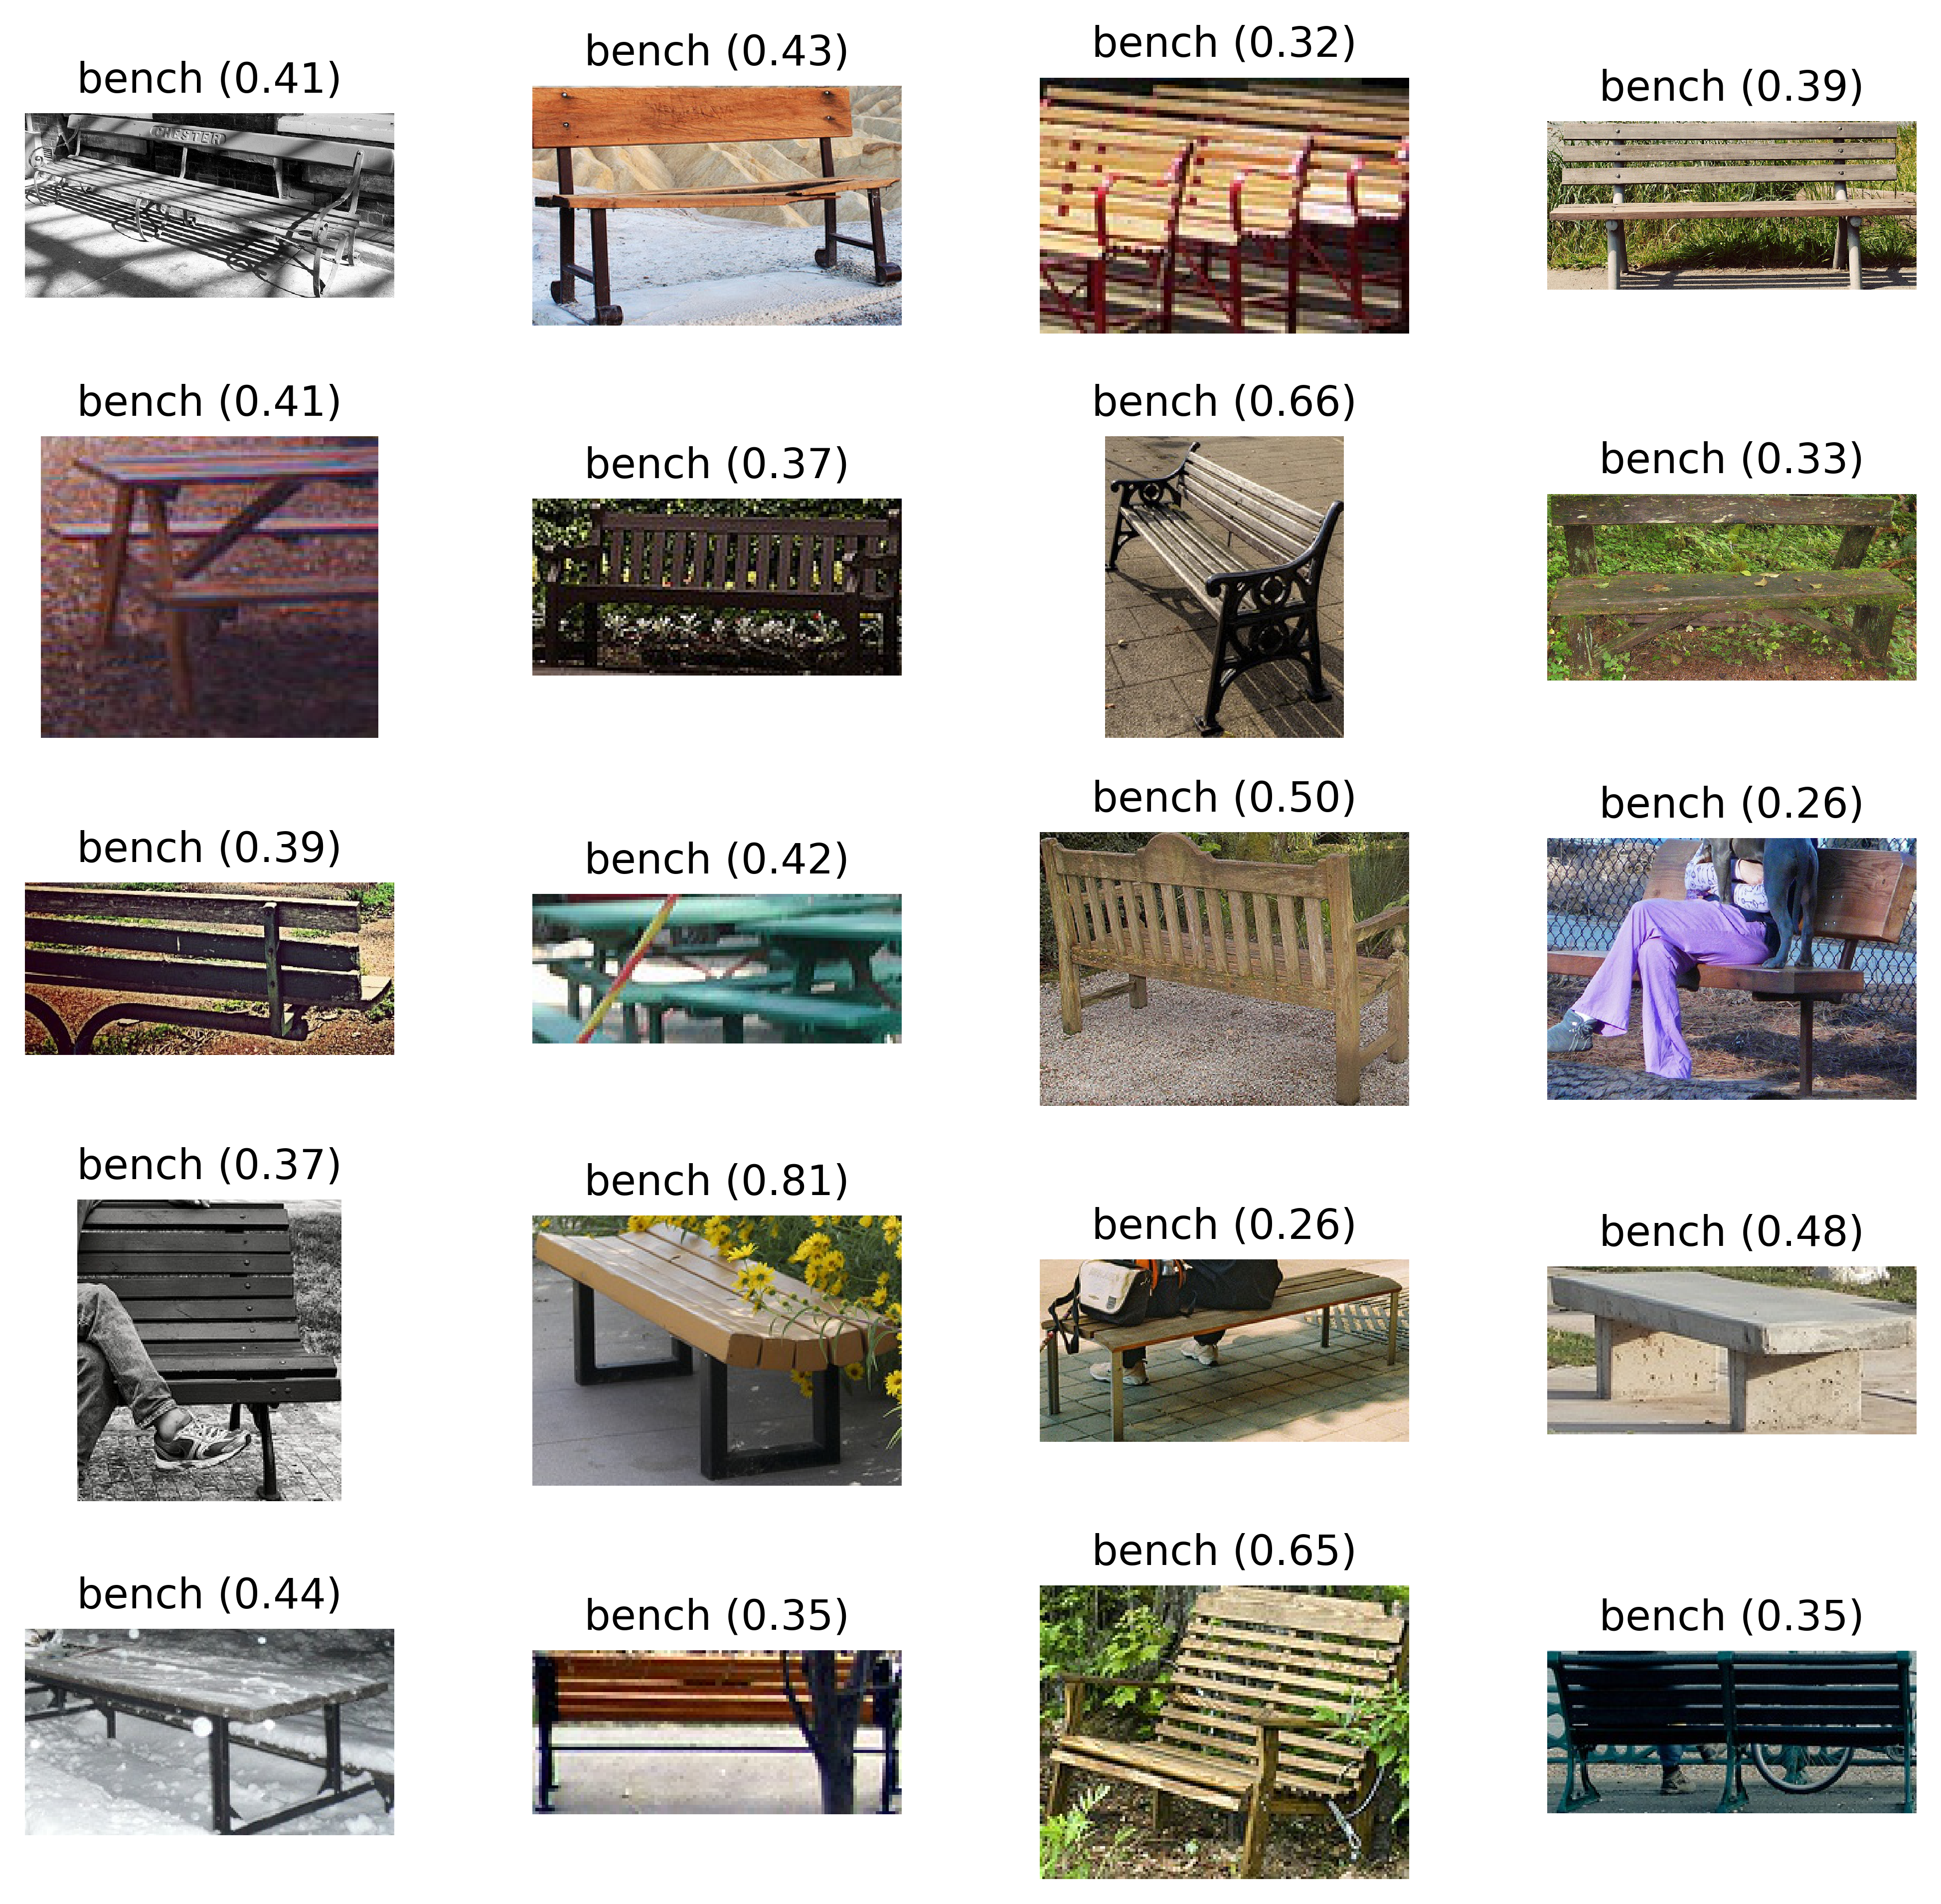

In [10]:
import numpy as np
import matplotlib.pyplot as plt

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
zeroshot_test_dataset = torchvision.datasets.ImageFolder(root="../data/coco_crops_zero_shot/test")
idx_to_classes = {value:key for key, value in zeroshot_test_dataset.class_to_idx.items()}

cnt = 0
for i in range(1, columns*rows +1):
    img = (zeroshot_test_dataset[cnt][0])
    
    fig.add_subplot(rows, columns, i)
    fig.tight_layout() 
    
    plt.title(idx_to_classes[zeroshot_test_dataset[cnt][1]] + " ({:.02f})".format(zeroshow_max_probas[cnt]))

    plt.imshow(img)
    plt.axis("off")
    cnt+=1

plt.show()